<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Difference-in-Difference" data-toc-modified-id="Difference-in-Difference-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Difference in Difference</a></span><ul class="toc-item"><li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Linear Regression</a></span></li></ul></li><li><span><a href="#Reference" data-toc-modified-id="Reference-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir(os.path.join('..', '..', 'notebook_format'))

from formats import load_style
load_style(plot_style=False)

In [2]:
os.chdir(path)

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

%watermark -a 'Ethen' -d -u -v -iv

Author: Ethen

Last updated: 2022-06-05

Python implementation: CPython
Python version       : 3.7.11
IPython version      : 7.27.0

matplotlib : 3.4.3
pandas     : 1.3.5
statsmodels: 0.13.1
numpy      : 1.21.6



# Difference in Difference

In advertising or marketing domain, advertisers are very much interested in knowing how do ads campaigns or marketing efforts effect on products' sales. A baseline approach to conduct these type of analysis is a pre and post comparison. i.e. We have a time window before launching the treatment, a pre-period, and a time window after launching the treatment, a post-period. We would then calculate our metric of interest between the two time window and calculate its difference. One drawback with this baseline approach is that, how do we tease out the effect of our treatment from other potential factors, such as marketplace trend. i.e. How do we know an increase or decrease in product sales is because of our ad/marketing campaign, or is it because of some seasonal trends that is influencing our products' sales.

Difference in Difference, or diff in diff in short, computes average treatment effect on the treated by comparing treatment group difference to control group difference, where difference refers to the difference between our two time window. 

\begin{align}
(E[Y(1)|T=1] - E[Y(1)|T=0]) - (E[Y(0)|T=1] - E[Y(0)|T=0])
\end{align}

Where, $T$ denote the treatment indicator, and $Y(W)$ denotes the outcome at time window $W$.


Using the example from [Notebook: Python Causality Handbook - Difference in Difference](https://matheusfacure.github.io/python-causality-handbook/13-Difference-in-Differences.html), say we wish to estimate whether billboard marketing increases deposits into our saving accounts. In our dataset, `deposits` is our outcome variable of interest, `poa` is a dummy indicator for the city of Porto Alegre, zero for Floraianopolis. `jul` is a dummy indicator for the month of July. Here we launched a billboard marketing campaign in the city of Porto Alegre, in other words, `poa`, is our treatment indicator, and `jul` is the pre-post time period indicator.

In [3]:
data = pd.read_csv("data/billboard_impact.csv")
print(data.shape)
data.head()

(4600, 3)


,deposits,poa,jul
0,42,1,0
1,0,1,0
2,52,1,0
3,119,1,0
4,21,1,0


We can calculate difference in difference by slicing our datsets into 4 segments, and calculating their mean differences. The difference and difference mentioned here is also referred to as 2x2 difference in difference, meaning there are two comparison groups, and our treatment occurs at a single point in time, splitting time into a pre and post period.

In [4]:
treatment_pre = data.loc[(data['poa'] == 1) & (data['jul'] == 0), 'deposits'].mean()
treatment_post = data.loc[(data['poa'] == 1) & (data['jul'] == 1), 'deposits'].mean()

control_pre = data.loc[(data['poa'] == 0) & (data['jul'] == 0), 'deposits'].mean()
control_post = data.loc[(data['poa'] == 0) & (data['jul'] == 1), 'deposits'].mean()

(treatment_post - control_post) - (treatment_pre - control_pre)

6.524557692307695

Result is telling us that we should expect deposits to increase by $6.52 per customer given the marketing campaign.

## Linear Regression

We can actually re-frame this type of difference in difference estimator with a linear regression that uses interaction variables.

\begin{align}
Y_i = \beta_0 + \beta_1 T_i + \beta_2 W_i + \beta_3 T_i*W_i + e_i
\end{align}

Where, $\beta_1$ is increment we get for going from control to treatment, $\beta_2$ is increment we get for going from pre to post period, and $\beta_3$ is increment for both effects, i.e. it is the difference in difference estimator. All 4 scenarios are also listed below:

- Pre, Control. $T_i = 0$, $W_i = 0$, $T_i * W_i = 0$
- Pre, Treatment. $T_i = 1$, $W_i = 0$, $T_i * W_i = 0$
- Post, Control. $T_i = 0$, $W_i = 1$, $T_i * W_i = 0$
- Post, Treatment. $T_i = 1$, $W_i = 1$, $T_i * W_i = 1$

In [5]:
smf.ols('deposits ~ poa * jul', data=data).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,171.6423,2.363,72.625,0.000,167.009,176.276
poa,-125.6263,4.484,-28.015,0.000,-134.418,-116.835
jul,34.5232,3.036,11.372,0.000,28.571,40.475
poa:jul,6.5246,5.729,1.139,0.255,-4.706,17.755


Our result indicated by column `poa:jul` should match the hand rolled calculation in the previous section.

**Pros:** Difference in difference has an intuitive explanation. Also by converting this problem into the form of linear regression, we get the benefit of: 1) Additional stats such as p-values, confidence intervals reported. 2) Not needing to segment the data ourselves to perform this type of calculation. This also has the benefit of when we wish to extend this vanilla framework to include other potential confounders that are lurking in our observational data, it would just be adding another feature/field to our linear regression model.

**Caveats:** Vanilla version of this method comes with a caveat that parallel trend assumption must hold. Meaning, in absence of a treatment, difference between our treatment and control group should be the same across the two time period. If this assumption holds true, then we can use difference in difference to tease out the treatment effect. On the other hand, if it doesn't hold true, then this method will be biased. This is very common when the treatment allocation is determined by baseline outcome, e.g. we decided to run our marketing campaign in one group because it isn't performing well in the first place.

Quickest way to confirm this parallel trend assumption, is to perform a visual inspection.

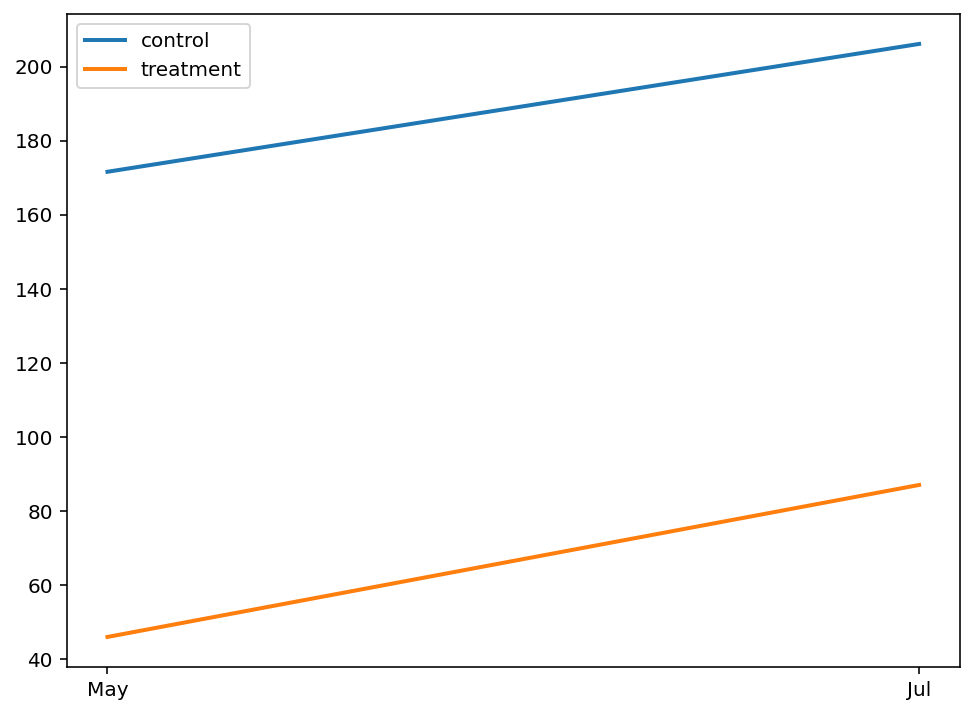

In [6]:
plt.figure(figsize=(8, 6))
plt.plot(["May", "Jul"], [control_pre, control_post], label="control", lw=2)
plt.plot(["May", "Jul"], [treatment_pre, treatment_post], label="treatment", lw=2)
plt.legend()
plt.show()

# Reference

- [Notebook: Python Causality Handbook - Difference in Difference](https://matheusfacure.github.io/python-causality-handbook/13-Difference-in-Differences.html)
- [Blog: Analyzing the Impact of Course Updates with Difference-in-Differences](https://medium.com/coursera-engineering/analyzing-the-impact-of-course-updates-with-difference-in-differences-9a0704be131c)
- [Blog: Using Back-Door Adjustment Causal Analysis to Measure Pre-Post Effects](https://doordash.engineering/2022/06/02/using-back-door-adjustment-causal-analysis-to-measure-pre-post-effects/)